## Import package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Exploration & Intuition

In [2]:
df_train=pd.read_csv("../original_data/mitbih_train.csv")
df_test=pd.read_csv("../original_data/mitbih_test.csv")

In [3]:
df_train.columns = np.arange(188)
df_test.columns = np.arange(188)

In [4]:
X_train_=df_train.iloc[:,:-1]
y_train=df_train.iloc[:,-1]
X_test=df_test.iloc[:,:-1]
y_test=df_test.iloc[:,-1]

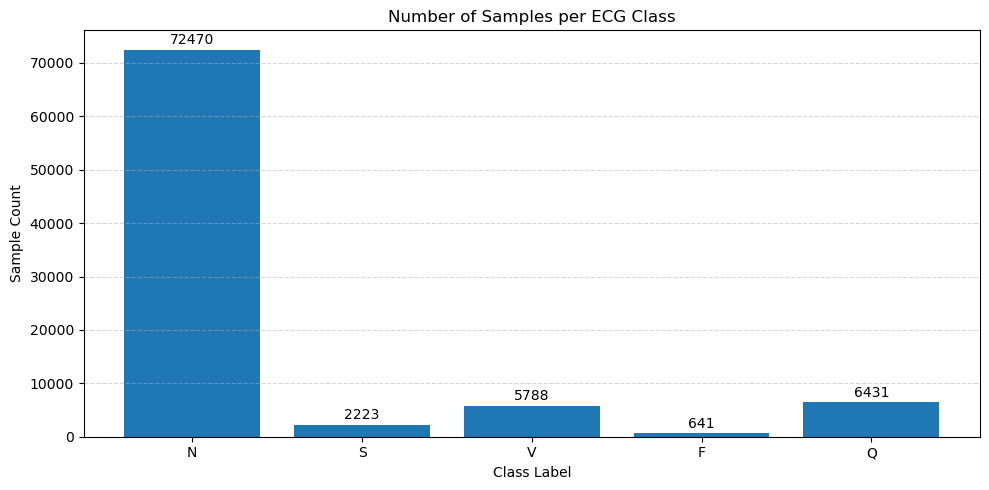

In [5]:
label_map = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

class_counts = y_train.value_counts().sort_index()

class_labels = [label_map[i] for i in class_counts.index]

plt.figure(figsize=(10, 5))
bars = plt.bar(class_labels, class_counts.values)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 500,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.title("Number of Samples per ECG Class")
plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


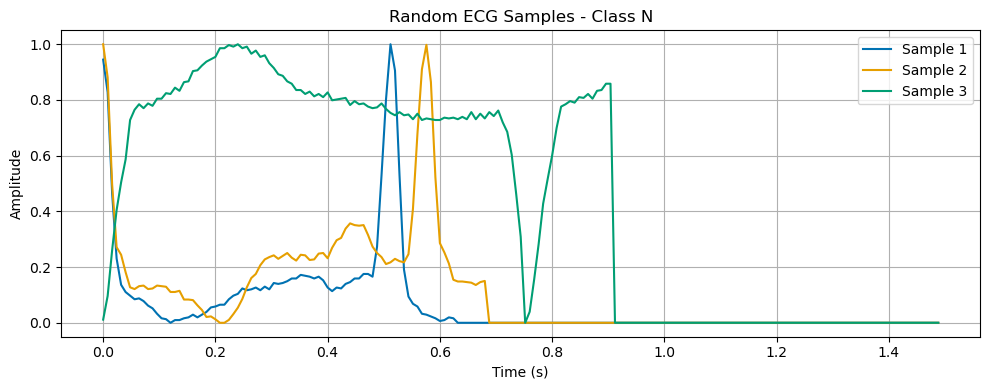

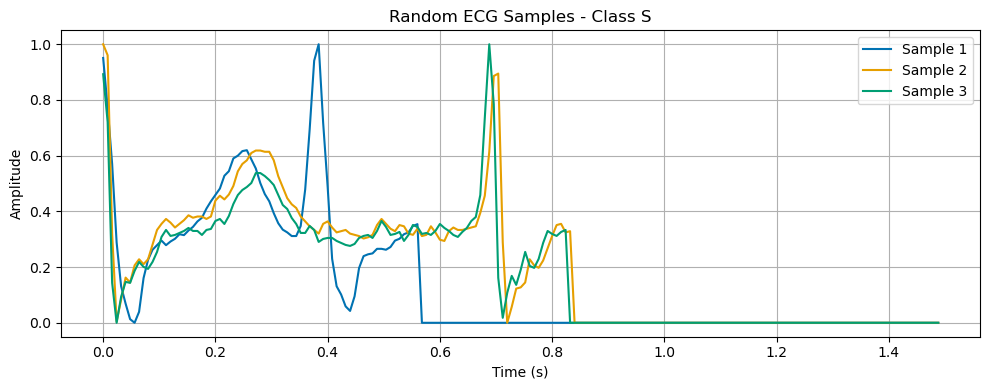

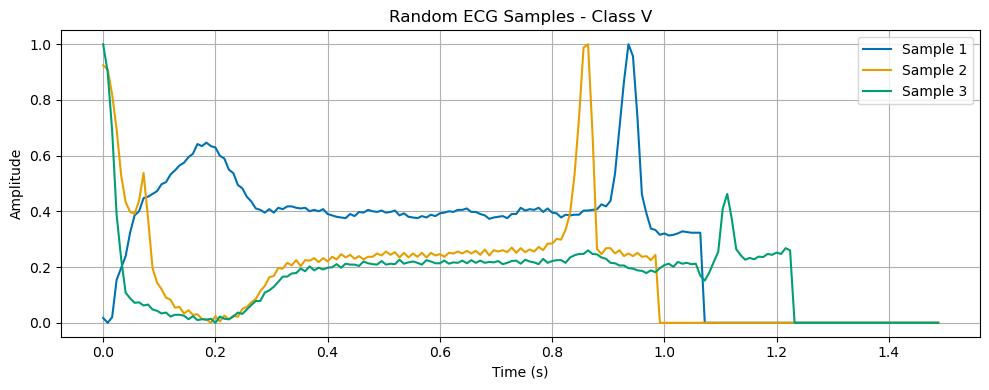

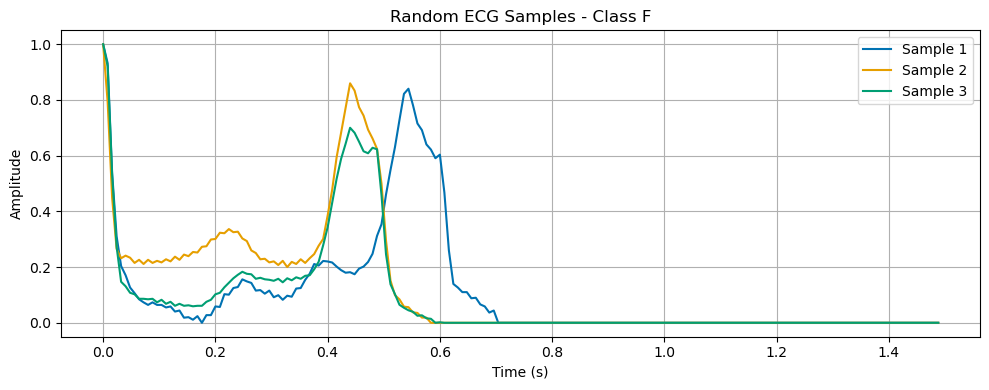

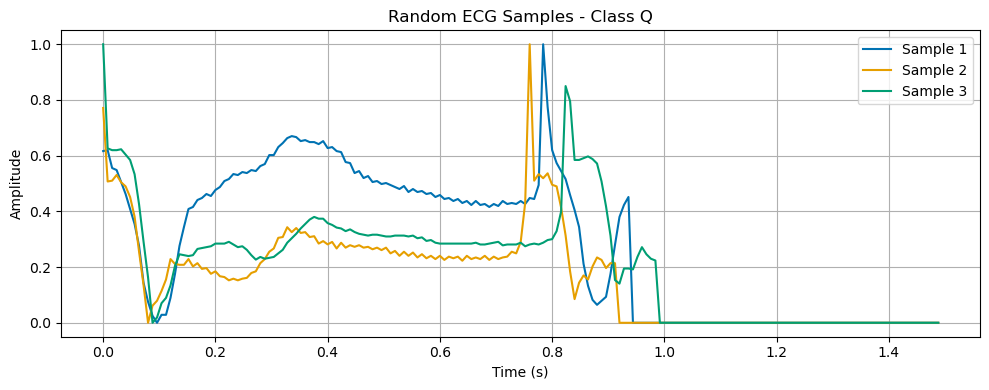

In [6]:
import numpy as np
import matplotlib.pyplot as plt

colors = ['#0072B2', '#E69F00', '#009E73']

classes = sorted(y_train.unique())
sampling_rate = 125  
t = np.arange(X_train_.shape[1]) / sampling_rate 

for label in classes:
    class_samples = X_train_[y_train == label]
    
    selected_samples = class_samples.sample(n=3, random_state=13).values

    plt.figure(figsize=(10, 4))
    for i, waveform in enumerate(selected_samples):
        plt.plot(t, waveform, label=f"Sample {i+1}",color=colors[i])

    plt.title(f"Random ECG Samples - Class {label_map[label]}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

93


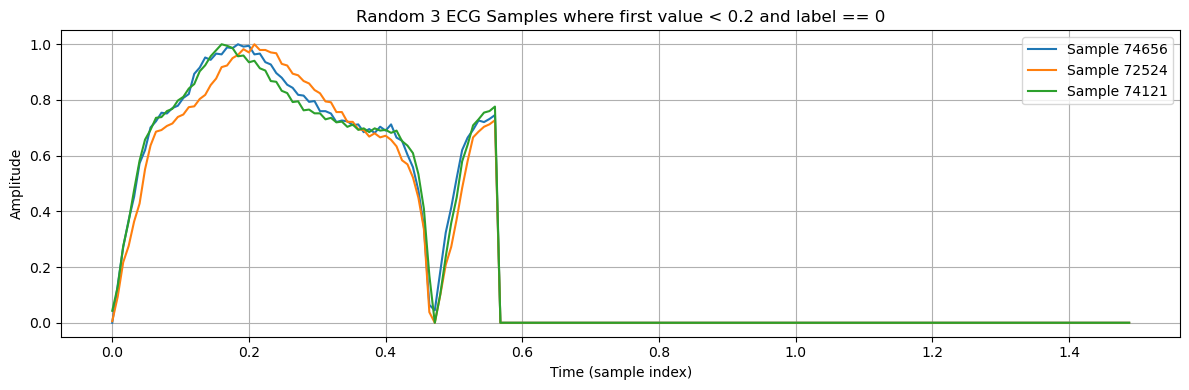

In [7]:

mask = (X_train_.iloc[:, 0] < 0.2) & (y_train == 1)
selected_indices = X_train_[mask].index
count = np.sum(mask)
print(count)

random_indices = np.random.choice(selected_indices, size=3, replace=False)
sampling_rate = 125  
t = np.arange(X_train_.shape[1]) / sampling_rate 

plt.figure(figsize=(12, 4))

for i, idx in enumerate(random_indices):
    plt.plot(t,X_train_.iloc[idx], label=f"Sample {idx}")

plt.title("Random 3 ECG Samples where first value < 0.2 and label == 0")
plt.xlabel("Time (sample index)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

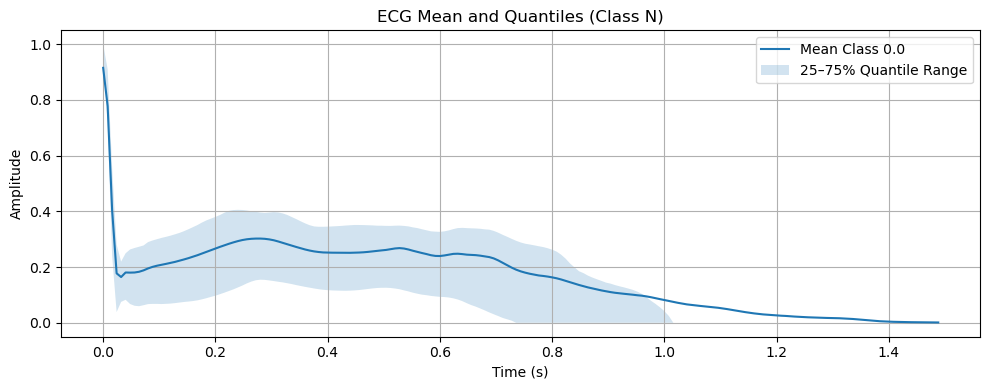

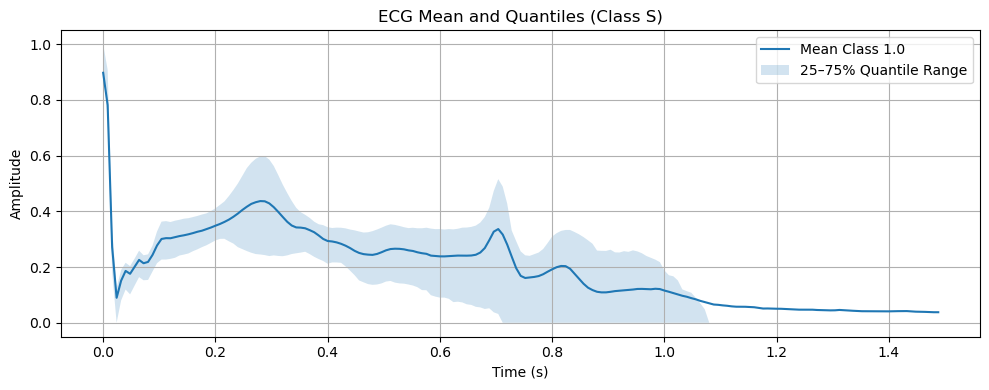

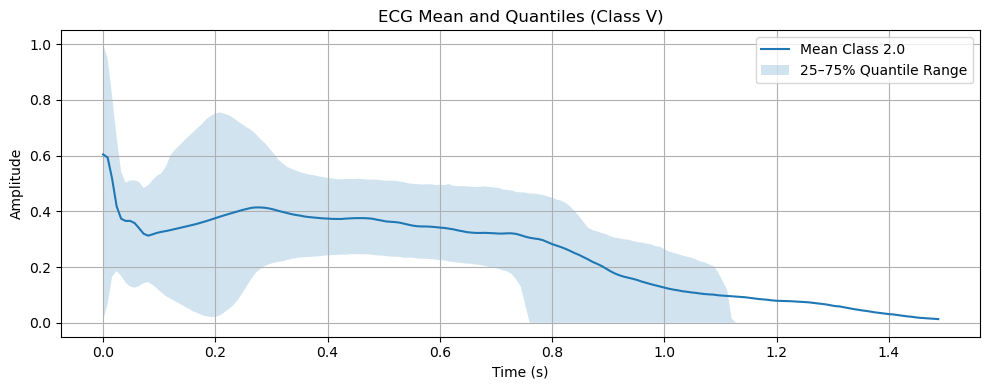

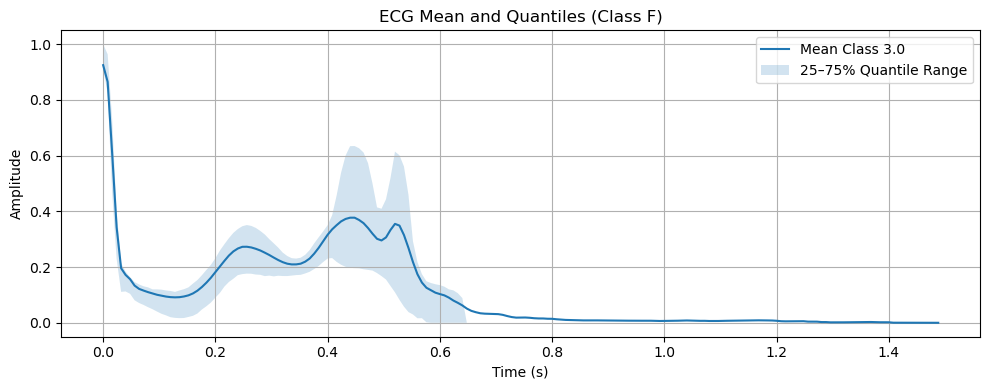

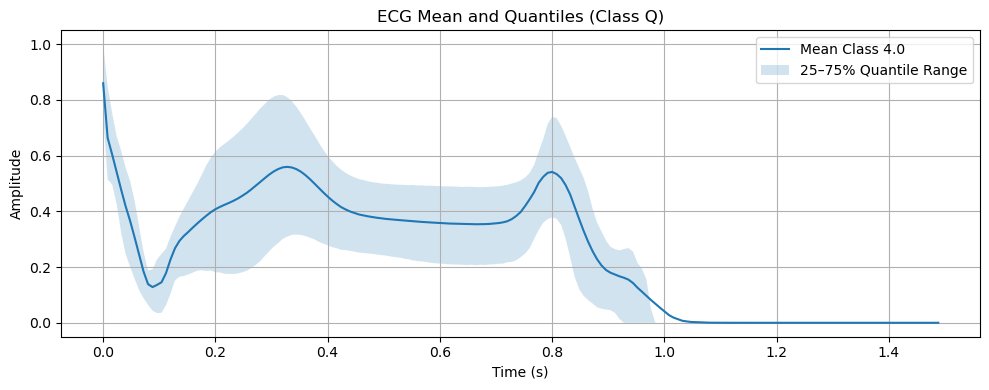

In [8]:
classes = sorted(y_train.unique())

lower_q = 0.25
upper_q = 0.75

for label in classes:
    class_samples = X_train_[y_train == label]
    
    mean_waveform = class_samples.mean(axis=0)
    lower_quantile = class_samples.quantile(lower_q, axis=0)
    upper_quantile = class_samples.quantile(upper_q, axis=0)
    
    t = np.arange(class_samples.shape[1]) / 125

    plt.figure(figsize=(10, 4))
    plt.plot(t, mean_waveform, label=f"Mean Class {label}")
    plt.fill_between(t, lower_quantile, upper_quantile, alpha=0.2,
                     label=f"{int(lower_q*100)}–{int(upper_q*100)}% Quantile Range")
    
    plt.title(f"ECG Mean and Quantiles (Class {label_map[label]})")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Resampling

In [9]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

under_sampler = RandomUnderSampler(sampling_strategy={0: 20000}, random_state=13) 
over_sampler = SMOTETomek(sampling_strategy={1: 20000, 
                                        2: 20000, 
                                        3: 20000, 
                                        4: 20000},random_state=13)

pipeline = Pipeline([
    ('under', under_sampler), 
    ('over', over_sampler)   
])

X_resampled, y_resampled = pipeline.fit_resample(X_train_, y_train)

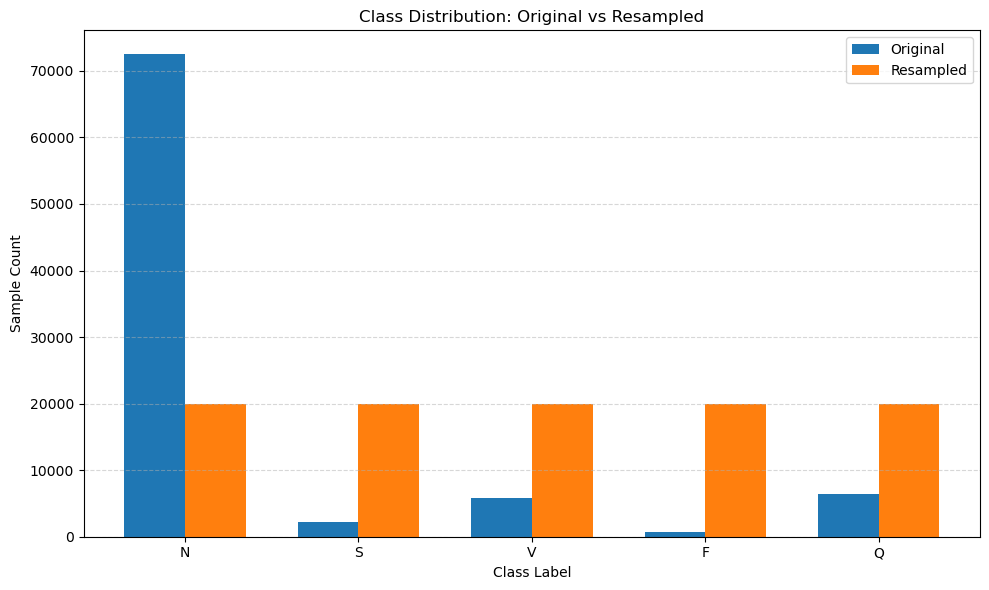

In [10]:
original_counts = y_train.value_counts().sort_index()
resampled_counts = pd.Series(y_resampled).value_counts().sort_index()

classes = original_counts.index.tolist()
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, original_counts.values, width=width, label="Original")
plt.bar(x + width/2, resampled_counts.values, width=width, label="Resampled")

plt.xlabel("Class Label")
plt.ylabel("Sample Count")
plt.title("Class Distribution: Original vs Resampled")
plt.xticks(x, class_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## XGBOOST

In [21]:
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

In [22]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100,300,500],
    'min_child_weight': [3,5,7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0.8],
    'reg_alpha': [0.5]
}

model = XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    random_state=13,
    tree_method='hist',   
    device='cuda'                  
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=13)

search = RandomizedSearchCV(
    estimator = model,
    param_distributions=param_grid,
    n_iter=20,
    scoring= 'recall_macro',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

search.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/pockyee/miniconda3/envs/dl/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/pockyee/miniconda3/envs/dl/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' var

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=13, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           gr...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_class=5, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8],
                                        'gamma': [0.8],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [3, 5, 7],
                                        'n_estimators': [100, 300, 500],
                                        'reg_alpha': [0.5],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='recall_macro', verbose=1)

In [23]:
search.best_params_

{'subsample': 0.6,
 'reg_alpha': 0.5,
 'n_estimators': 300,
 'min_child_weight': 5,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 0.8,
 'colsample_bytree': 0.8}

In [24]:
xgb_model = search.best_estimator_

In [25]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred,digits=3))

              precision    recall  f1-score   support

         0.0      0.990     0.924     0.956     18117
         1.0      0.368     0.788     0.502       556
         2.0      0.829     0.943     0.882      1448
         3.0      0.283     0.864     0.426       162
         4.0      0.958     0.973     0.965      1608

    accuracy                          0.925     21891
   macro avg      0.685     0.898     0.746     21891
weighted avg      0.956     0.925     0.936     21891



In [26]:
y_train_pred = xgb_model.predict(X_resampled)
print(classification_report(y_resampled, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     19990
         1.0       0.96      0.95      0.96     19996
         2.0       0.99      0.97      0.98     19997
         3.0       0.97      0.99      0.98     20000
         4.0       1.00      0.99      0.99     19997

    accuracy                           0.97     99980
   macro avg       0.97      0.97      0.97     99980
weighted avg       0.97      0.97      0.97     99980



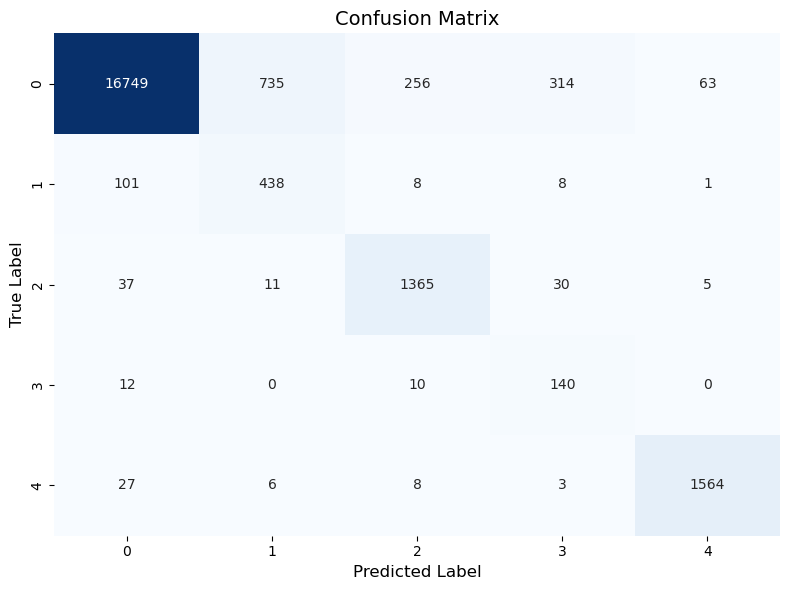

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [28]:
xgb_model.save_model('xgb_model.json')